In [31]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from cv2 import imshow

In [2]:
train_path="train_frames"
test_path="test_frames"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [3]:
print(class_names)
print(class_names_test)

['Bye ', 'Nice ', 'Welcome', 'No ', 'Yes', 'Work', 'Hello', 'House ', 'Thank You', 'Morning', 'Good ']
['Bye', 'Work ', 'House', 'No', 'Nice', 'Good', 'Yes ', 'Hello', 'Thank You', 'Morning', 'Welcome ']


In [4]:
path = 'train_frames'
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(227,227), class_mode='categorical')

Found 7850 images belonging to 11 classes.


/home/hena/.local/lib/python3.10/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]')

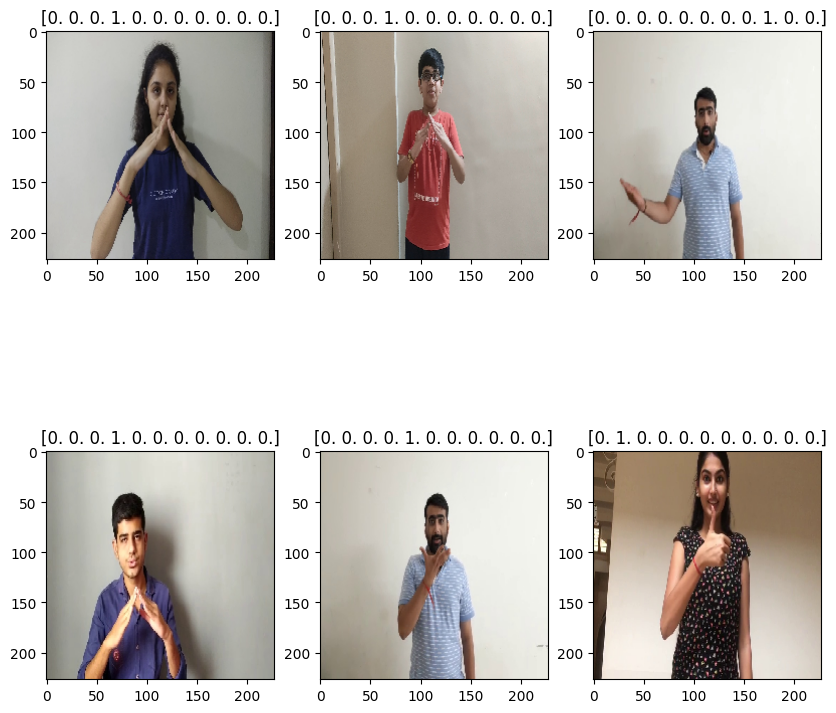

In [5]:
fig , axs = plt.subplots(2,3 ,figsize = (10,10))
axs[0][0].imshow(train[0][0][12])
axs[0][0].set_title(train[0][1][12])
axs[0][1].imshow(train[0][0][10])
axs[0][1].set_title(train[0][1][10])
axs[0][2].imshow(train[0][0][5])
axs[0][2].set_title(train[0][1][5])
axs[1][0].imshow(train[0][0][20])
axs[1][0].set_title(train[0][1][20])
axs[1][1].imshow(train[0][0][25])
axs[1][1].set_title(train[0][1][25])
axs[1][2].imshow(train[0][0][3])
axs[1][2].set_title(train[0][1][3])

In [6]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,shuffle=True,class_mode='categorical')

Found 7850 images belonging to 11 classes.
Found 7589 images belonging to 11 classes.


In [8]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [9]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [10]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [11]:
base_model = ResNet50(input_shape=(224, 224, 3))

2023-03-15 18:58:46.116184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hena/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-15 18:58:46.116214: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 18:58:46.116236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hena029): /proc/driver/nvidia/version does not exist
2023-03-15 18:58:46.132341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

In [12]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 11,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [13]:
model = Model(inputs=base_model.input, outputs=headModel)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 55, 55, 64)   0           ['bn2c_branch2b[0][0]']          
                                                                                                  
 res2c_branch2c (Conv2D)        (None, 55, 55, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 55, 55, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 55, 55, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
          

 ion)                                                                                             
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 512)  0           ['bn3c_branch2c[0][0]',          
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 28, 28, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 28, 28, 128)  512        ['res3d_branch2a[0][0]']         
 ion)     

 add_8 (Add)                    (None, 14, 14, 1024  0           ['bn4b_branch2c[0][0]',          
                                )                                 'activation_24[0][0]']          
                                                                                                  
 activation_27 (Activation)     (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 res4c_branch2a (Conv2D)        (None, 14, 14, 256)  262400      ['activation_27[0][0]']          
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, 14, 14, 256)  1024       ['res4c_branch2a[0][0]']         
 ion)                                                                                             
          

                                                                                                  
 res4f_branch2a (Conv2D)        (None, 14, 14, 256)  262400      ['activation_36[0][0]']          
                                                                                                  
 bn4f_branch2a (BatchNormalizat  (None, 14, 14, 256)  1024       ['res4f_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_37 (Activation)     (None, 14, 14, 256)  0           ['bn4f_branch2a[0][0]']          
                                                                                                  
 res4f_branch2b (Conv2D)        (None, 14, 14, 256)  590080      ['activation_37[0][0]']          
                                                                                                  
 bn4f_bran

 ion)                                                                                             
                                                                                                  
 activation_46 (Activation)     (None, 7, 7, 512)    0           ['bn5c_branch2a[0][0]']          
                                                                                                  
 res5c_branch2b (Conv2D)        (None, 7, 7, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 bn5c_branch2b (BatchNormalizat  (None, 7, 7, 512)   2048        ['res5c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_47 (Activation)     (None, 7, 7, 512)    0           ['bn5c_branch2b[0][0]']          
          

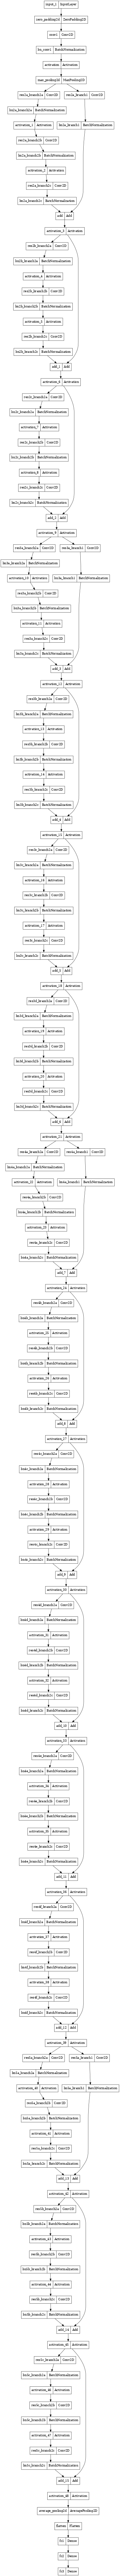

In [15]:
tf.keras.utils.plot_model(
    model, to_file='resnet.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=45
)


In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
#Datasets parameters
BATCH_SIZE = 32
IMG_SIZE = (224,224)
num_of_test_samples=7589

In [18]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7850 files belonging to 11 classes.
Found 7589 files belonging to 11 classes.


In [19]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10


/home/hena/.local/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


246/246 [==============================] - 4042s 16s/step - loss: 1.1901 - accuracy: 0.6482 - val_loss: 2.4707 - val_accuracy: 0.1385
Epoch 2/10
246/246 [==============================] - 4015s 16s/step - loss: 0.0899 - accuracy: 0.9786 - val_loss: 0.3126 - val_accuracy: 0.9070
Epoch 3/10
246/246 [==============================] - 4158s 17s/step - loss: 0.1054 - accuracy: 0.9724 - val_loss: 0.9480 - val_accuracy: 0.7365
Epoch 4/10
246/246 [==============================] - 4249s 17s/step - loss: 0.0778 - accuracy: 0.9805 - val_loss: 0.0812 - val_accuracy: 0.9750
Epoch 5/10
246/246 [==============================] - 4380s 18s/step - loss: 0.0663 - accuracy: 0.9815 - val_loss: 0.1200 - val_accuracy: 0.9631
Epoch 6/10
246/246 [==============================] - 4201s 17s/step - loss: 0.0547 - accuracy: 0.9851 - val_loss: 0.6156 - val_accuracy: 0.8395
Epoch 7/10
246/246 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9903 

2023-03-16 02:53:03.390580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 256
2023-03-16 02:53:12.220503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 87 of 256
2023-03-16 02:53:21.682773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 228 of 256
2023-03-16 02:53:23.394299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 4123s 17s/step - loss: 0.0419 - accuracy: 0.9903 - val_loss: 0.4009 - val_accuracy: 0.8773
Epoch 8/10
246/246 [==============================] - 4034s 16s/step - loss: 0.0470 - accuracy: 0.9885 - val_loss: 0.1986 - val_accuracy: 0.9447
Epoch 9/10
246/246 [==============================] - 4038s 16s/step - loss: 0.0474 - accuracy: 0.9885 - val_loss: 0.5757 - val_accuracy: 0.8721
Epoch 10/10
246/246 [==============================] - 4044s 16s/step - loss: 0.0519 - accuracy: 0.9861 - val_loss: 0.9588 - val_accuracy: 0.8308


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

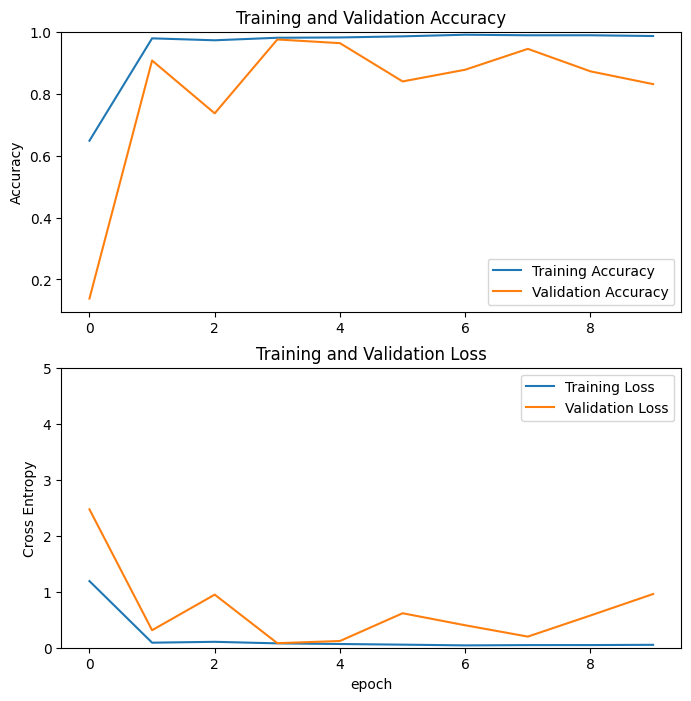

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(test_path,IMG_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Found 7589 images belonging to 11 classes.


In [28]:
Y_pred = model.predict(test_generator)

238/238 [==============================] - 697s 3s/step


In [35]:
y_pred = np.argmax(Y_pred, axis=1)

In [36]:
labels=['Bye','Work ','House','No','Nice','Good','Yes ','Hello','Thank You','Morning','Welcome ']

In [32]:
cm = confusion_matrix(test_generator.classes, y_pred)

In [33]:
print(cm)

[[  0   0   0   0   0   0   0 691   0   0   0]
 [  0   0   0   0   0   0   0 653   0   0   0]
 [  0   0   0   0   0   0   0 694   0   0   0]
 [  0   0   0   0   0   0   0 683   0   0   0]
 [  0   0   0   0   0   0   0 671   0   0   0]
 [  0   0   0   0   0   0   0 755   0   0   0]
 [  0   0   0   0   0   0   0 572   0   0   0]
 [  0   0   0   0   0   0   0 713   0   0   0]
 [  0   0   0   0   0   0   0 690   0   0   0]
 [  0   0   0   0   0   0   0 740   0   0   0]
 [  0   0   0   0   0   0   0 727   0   0   0]]


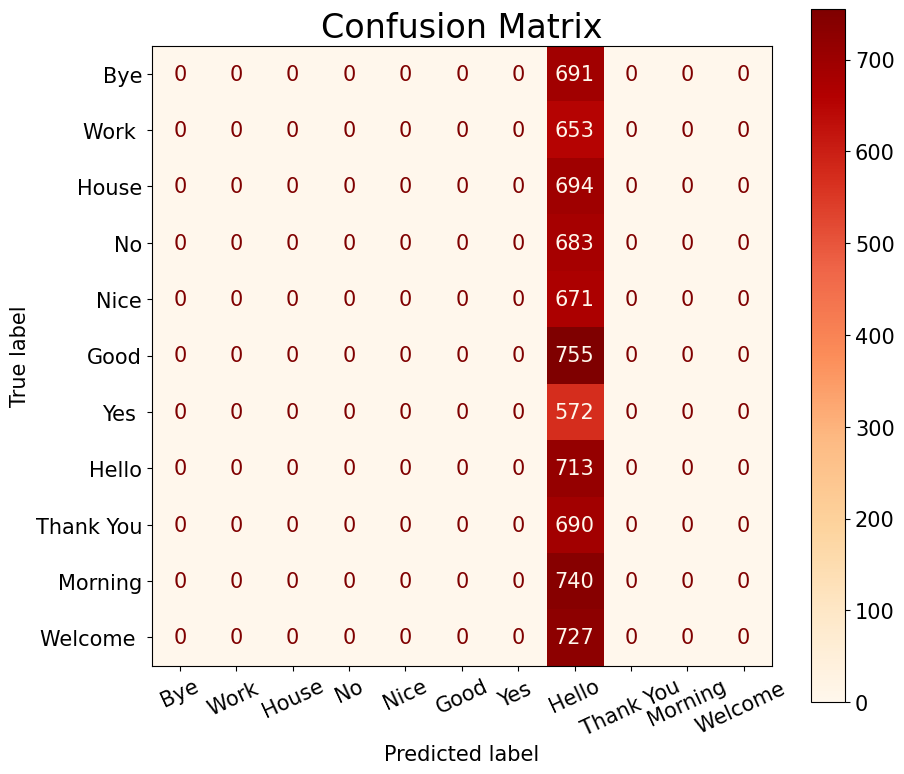

In [37]:
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 15
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=24)
plt.savefig('confusion_matrix_resnet.png', transparent=True, dpi=400)
plt.show()